In [14]:
# we'll be using these services
import owslib.wms
import owslib.wcs
import owslib.wfs
from io import BytesIO, StringIO
import os
import json
import shapely.geometry

In [15]:
import matplotlib.style
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
%matplotlib inline

Web Maps
=========

In [16]:
# this is the dataset of dutch altimetry
url = 'http://geodata.nationaalgeoregister.nl/ahn2/wms'

In [17]:
# we're using WMS for rendered maps
wms = owslib.wms.WebMapService(url)


In [18]:
# let's see what the server offers.
wms.contents

{'ahn2_05m_int': <owslib.wms.ContentMetadata at 0x75a07b8>,
 'ahn2_05m_non': <owslib.wms.ContentMetadata at 0x75a0278>,
 'ahn2_05m_ruw': <owslib.wms.ContentMetadata at 0x75a0748>,
 'ahn2_5m': <owslib.wms.ContentMetadata at 0x75a07f0>,
 'ahn2_bladindex': <owslib.wms.ContentMetadata at 0x75a0898>}

In [19]:
# let's zoom in on delft
(top,left, bottom, right) = (52.0144342,4.3053329,51.984102,4.3947685)
# define a bounding box
bbox = (left, bottom, right, top) 
# and get a map
f = wms.getmap('ahn2_05m_ruw', bbox=bbox, size=(256, 256))

In [20]:
# oops, we missed some inputs
import logging
logging.warn(f.read())

In [21]:
# let's specify some more details, 
# We want WGS84 and we want a bigger map
f = wms.getmap(['ahn2_5m'], srs='EPSG:4326', bbox=bbox, size=(1024, 1024), format='image/png', transparent=True)

In [22]:
# convert binary data to IO stream
f_io = BytesIO(f.read())
img = plt.imread(f_io)

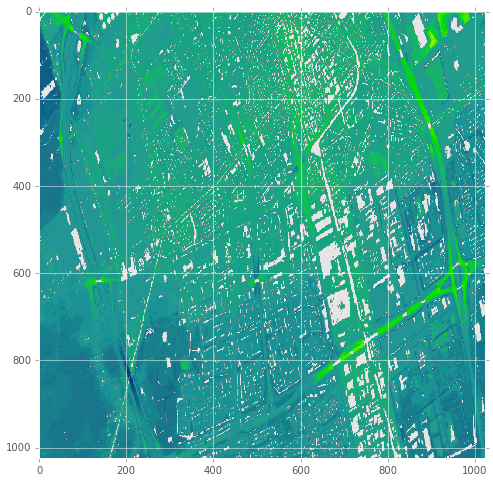

In [23]:
plt.subplots(figsize=(13,8))
plt.imshow(img)

In [44]:
# let's find out some more details about the server
print(wms.getServiceXML().decode('ascii'))

<WMT_MS_Capabilities xmlns:xlink="http://www.w3.org/1999/xlink" updateSequence="1913" version="1.1.1">
  <Service>
    <Name>OGC:WMS</Name>
    <Title>Actueel Hoogtebestand Nederland 2</Title>
    <Abstract>Actueel Hoogtebestand Nederland 2</Abstract>
    <KeywordList>
      <Keyword>WMS</Keyword>
      <Keyword>PDOK</Keyword>
      <Keyword>infoMapAccessService</Keyword>
    </KeywordList>
    <OnlineResource xlink:href="http://geodata.nationaalgeoregister.nl/" xlink:type="simple" />
    <ContactInformation>
      <ContactPersonPrimary>
        <ContactPerson>KlantContactCenter PDOK</ContactPerson>
        <ContactOrganization>PDOK</ContactOrganization>
      </ContactPersonPrimary>
      <ContactPosition>pointOfContact</ContactPosition>
      <ContactAddress>
        <AddressType>Work</AddressType>
        <Address />
        <City>Apeldoorn</City>
        <StateOrProvince />
        <PostCode />
        <Country>Nederland</Country>
      </ContactAddress>
      <ContactVoiceTelephon

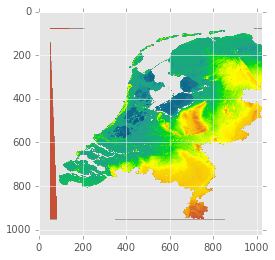

In [27]:
# let's zoom out
(top,left, bottom, right) = (53.8,3,50.5,7.1)
bbox = (left, bottom, right, top) 
f = wms.getmap(['ahn2_5m'], srs='EPSG:4326', bbox=bbox, size=(1024, 1024), format='image/png', transparent=True)
f_io = BytesIO(f.read())
img = plt.imread(f_io)
plt.imshow(img)

In [28]:
(top,left, bottom, right) = (52.05,4.30,51.95,4.40)
bbox = (left, bottom, right, top) 

f = wms.getmap(['ahn2_5m'], srs='EPSG:4326', bbox=bbox, size=(1024, 1024), format='application/vnd.google-earth.kml', transparent=True)
open('file.kml', 'w').write(f.read().decode('ascii'))

os.system('file.kml')

1

Web coverage
=============

In [29]:
url='http://geodata.nationaalgeoregister.nl/ahn2/wcs'
wcs = owslib.wcs.WebCoverageService(url=url, 
                                    version="1.0.0") # version is actually 1.1.1, 1.2.0 
meta = wcs.contents['ahn2:ahn2_5m']
bbox = meta.boundingBoxWGS84


In [30]:
# How do we get this to work?
f = wcs.getCoverage(identifier='ahn2:ahn2_5m',
                bbox=bbox, 
                format='GeoTIFF',
                crs='EPSG:28992', 
                version="1.0.0",
                resx=5, resy=5)
f.read()[1:1000]

b'?xml version="1.0" encoding="UTF-8"?><ServiceExceptionReport version="1.2.0" >   <ServiceException>\n      java.lang.IllegalArgumentException: Illegal value for argument &quot;resolutions&quot;.\nIllegal value for argument &quot;resolutions&quot;.\n</ServiceException></ServiceExceptionReport>'

Web Feature Service
==================

In [31]:
url = 'http://geodata.nationaalgeoregister.nl/ahn2/wfs'
wfs = owslib.wfs.WebFeatureService(url, version="2.0.0")
# only one layer
wfs.contents
print(wfs)

In [32]:
layer = wfs.contents['ahn2:ahn2_bladindex']
layer = list(wfs.contents.values())[0]


In [39]:
# let's read the features
f = wfs.getfeature(typename=[layer.id], outputFormat="json")

data = json.loads(f.read().decode('ascii'))

shapes = []
for feature in data['features']:
    shapes.append(shapely.geometry.asShape(feature['geometry'])[0])

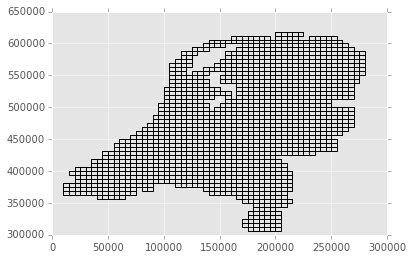

In [40]:
import numpy as np
for shape in shapes:
    xy = np.array(shape.exterior.coords)
    plt.plot(xy[:,0], xy[:,1], 'k-')

In [41]:
data['features'][0]

{'geometry': {'coordinates': [[[[200000, 618750],
     [205000, 618750],
     [205000, 612500],
     [200000, 612500],
     [200000, 618750]]]],
  'type': 'MultiPolygon'},
 'geometry_name': 'geom',
 'id': 'ahn2_bladindex.1',
 'properties': {'bladnr': '02ez1',
  'cellsize': '5',
  'datum': '2008-02-14Z',
  'geom_valid': True,
  'lo_x': '200000',
  'lo_y': '612500',
  'max_datum': '2008-03-04Z',
  'min_datum': '2008-02-14Z',
  'update': '2009-05-27Z'},
 'type': 'Feature'}

In [21]:
# Challenge
# read point cloud from http://geodata.nationaalgeoregister.nl/ahn2/atom/ahn2_uitgefilterd.xml